<a href="https://colab.research.google.com/github/chaiwencw/CPO-Price-Forecasting-Using-Simulated-Annealing-based-Support-Vector-Regression/blob/main/Analysis1%3A%20Different%20Training%20Size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Import Packages

In [ ]:
# uncomment the code below to install the plotly package if it is not detected in the current environment
# pip install plotly 

In [ ]:
import pandas as pd                                   # to deal with pandas dataframe
import numpy as np                                    # to deal with numbers
import datetime as dt                                 # to deal with datetime data
import time                                           # to record execution time
from math import ceil                                 # ceiling function for calculation
import plotly.graph_objects as go                     # to plot graphs
from matplotlib import pyplot as plt                  # to plot graphs
from statsmodels.graphics import tsaplots             # to plot graphs
from sklearn.preprocessing import PowerTransformer    # to make data more Gaussian-like
from sklearn.model_selection import train_test_split  # to split data arrays into two subsets
#from SA_parameter_optimization import *               # import all (methods, variables...) from SA_parameter_optimization

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Section 1: Data Pre-processing
This section shows importing necessary packages, and data importation and cleaning.

## Section 1.1: Import Data


In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/jc-usm/FYP-USM_2021-2022/main/FYP_Data.csv', na_values='-')               # read FCPO dataset
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")  # convert Date column to datatime format
data.head()                                                     # show the first 5 rows of the data for review

,Date,Open,Close,High,Low,Volume,Percentage Change
0,2018-01-02,2466,2472,2481,2466,100.0,0.0115
1,2018-01-03,2476,2555,2555,2476,500.0,0.0336
2,2018-01-04,2538,2542,2551,2533,470.0,-0.0051
3,2018-01-05,2554,2570,2561,2527,250.0,0.0110
4,2018-01-08,2541,2590,2572,2530,160.0,0.0078


* Open: Price when the market begin
* Close: Price when the market closed
* High: Highest price reached during that day
* Low: Lowest price traded on that day
* Volume: Total amount traded on that day
* Percentage Change: 

## Section 1.2: Data Cleaning

In [ ]:
data.info()                                                     # print information summary of the dataset 
null = data.isnull().sum()                                      # find the total no. of missing values in each column
df_null = pd.DataFrame(data = null, columns = ['No. of Null'])  # create a dataframe to show the number of null
print('\n\n', df_null)                                          # number of null in each column is shown
print(f'\n\nThe total no. of null is  {sum(null)}')             # the total number of null is shown

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1099 non-null   datetime64[ns]
 1   Open               1099 non-null   int64         
 2   Close              1099 non-null   int64         
 3   High               1099 non-null   int64         
 4   Low                1099 non-null   int64         
 5   Volume             1038 non-null   float64       
 6   Percentage Change  1099 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 60.2 KB


                    No. of Null
Date                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                      61
Percentage Change            0


The total no. of null is  61


In [ ]:
data_cleaned = data.dropna()  # drop all missing values 
data_cleaned.info()           # check the dataset information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1098
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1038 non-null   datetime64[ns]
 1   Open               1038 non-null   int64         
 2   Close              1038 non-null   int64         
 3   High               1038 non-null   int64         
 4   Low                1038 non-null   int64         
 5   Volume             1038 non-null   float64       
 6   Percentage Change  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 64.9 KB


In [ ]:
# create lag features: previous day open, high, low, close prices & volume & percentage change 
new_data = data_cleaned.copy()
for col in new_data.drop({'Open','Date', 'Close'}, axis=1).columns:
  new_data[f'Prev_{col}'] = new_data[col].shift(periods=1)
  new_data = new_data.drop(columns = col, axis=1) 

In [ ]:
# remove first row of dataset
new_data = new_data.iloc[1:,:] 

In [ ]:
# extract year, month, day etc. from Date
newdate = new_data['Date']
exact_trading_date = pd.DataFrame({'Year': newdate.dt.year,
                                    'Month': newdate.dt.month,
                                    'Day_of_Month': newdate.dt.day,
                                    'Day_of_Year': newdate.dt.dayofyear,
                                    'Week_of_Year': newdate.dt.isocalendar().week,
                                    'Day_of_Week': newdate.dt.isocalendar().day,
                                    'Weekday': newdate.dt.weekday,
                                    'Quarter': newdate.dt.quarter,
                                    })
new_data = pd.concat([exact_trading_date, new_data], axis = 1)
new_data = new_data.set_index('Date')
new_data.head()

,Year,Month,Day_of_Month,Day_of_Year,Week_of_Year,Day_of_Week,Weekday,Quarter,Open,Close,Prev_High,Prev_Low,Prev_Volume,Prev_Percentage Change
Date,,,,,,,,,,,,,,
2018-01-03,2018,1,3,3,1,3,2,1,2476,2555,2481.0,2466.0,100.0,0.0115
2018-01-04,2018,1,4,4,1,4,3,1,2538,2542,2555.0,2476.0,500.0,0.0336
2018-01-05,2018,1,5,5,1,5,4,1,2554,2570,2551.0,2533.0,470.0,-0.0051
2018-01-08,2018,1,8,8,2,1,0,1,2541,2590,2561.0,2527.0,250.0,0.0110
2018-01-09,2018,1,9,9,2,2,1,1,2563,2562,2572.0,2530.0,160.0,0.0078


## Section 3.3 Data Splitting & Transformation

In [ ]:
# specify feature columns and the target
features = new_data.drop(columns = ['Close'])
target = np.array(new_data['Close'])

In [ ]:
# to import the SVR model for price prediction
from sklearn.svm import SVR
# to import different evaluation metrics for regression problem
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# each evaluation metric is assigned to a shorter name for easy reference
MAE = mean_absolute_error
MAPE = mean_absolute_percentage_error
MSE = mean_squared_error
R2 = r2_score


def RegressionMetric(valid_data, predictions):
    """
    Produce 4 different evaluation metrics at once

    valid_data - Testing Value
    predictions - Predicted Value
    """

    # each eveluation metric is contained in a list
    metrics = [MAE, MAPE, MSE, R2]
    # create an empty list to keep all eveluation metrics
    metric_value = []
    # loop through different evaluation metrics and output the value
    for metric in metrics:
        metric_value.append(metric(valid_data, predictions))
    print("MAE:\t", metric_value[0])
    print("MAPE:\t", metric_value[1]) 
    print("RMSE:\t", np.sqrt(metric_value[2]))
    print("r2:\t", metric_value[3])


def model_training(Xtrain, Ytrain, Xvalid, Yvalid, current_parameters = None, constant_parameters = None):
    """
    Train the model with given set of hyperparameters and output metric

    current_parameters - Dict of hyperparameters and chosen values
    constant_parameters - Dict of hyperparameters that are kept constant
    Xtrain - Training Features
    Xvalid - Testing Features
    Ytrain - Training Value
    Yvalid - Testing Value
    """

    # to avoid assignment of closure object
    if current_parameters is None: current_parameters = {}
    if constant_parameters is None: constant_parameters = {}
    # copy the constant parameters dictionary
    parameters_copy = constant_parameters.copy()
    # combine the two constant and current parameters dictionary
    parameters_copy.update(current_parameters)
    # "**" is used to input a dict that contains all the key which are same as the arguments of the mdoel    
    model = SVR(**parameters_copy)
    # "fit" is used to train the model
    model.fit(Xtrain, Ytrain)
    # "predict" is used to make prediction
    predictions = model.predict(Xvalid)
    # MSE of the model is obtained
    metric_value = MSE(Yvalid, predictions)

    return metric_value


def parameters_choosing(potential_parameters, size_potential_parameters, current_parameters = None):
    """
    Function to choose parameters for next iteration
    
    Inputs:
    potential_parameters - Ordered dictionary of parameter search space
    current_parameters - Dict of current parameters
    size_potential_parameters - size of parameters search space

    Output:
    Dictionary of New Parameters
    """

    #when current parameters is non-empty dict
    if current_parameters:
        # copy current parameters dict to another dict called "new parameters"
        new_parameters = current_parameters.copy()
        # change the "keys" of the potential parameters dict into list
        potential_param_keys = [*potential_parameters.keys()]
        # randomly choose one parameter to be updated
        param_to_update = np.random.choice(potential_param_keys)
        # obtain the potential values for the parameter-to-be-updated
        potential_param_values = potential_parameters[param_to_update]
        # obtain the number of potential parameters
        no_potential_param_val = size_potential_parameters[param_to_update]
        # randomely generate one number as index out of theof the potential parameters
        random_index = np.random.randint(1, no_potential_param_val)
        # find the current index of the value of the parameter-to-be-updated
        curr_param_val_index = potential_param_values.index(current_parameters[param_to_update])
        # calculate the new index
        new_index = curr_param_val_index + np.random.choice([-1, 1])*random_index

        # try this block of code if there is no index error and a new paramater value will be assigned
        try:
            new_parameters[param_to_update] = potential_param_values[new_index]
        # if index is out of the range, then an IndexError is raised
        # new parameter is randomly assigned to either the first or the last value of potential parameters
        except IndexError:
            new_parameters[param_to_update] = potential_param_values[np.random.choice([-1, 0])]

    # when current parameters is empty dict
    else:
        # create a new empty dict
        new_parameters = {}
        # randomly assign the potential values to the parameters
        for key, value in potential_parameters.items():
            new_parameters[key] = np.random.choice(value)
        
    return new_parameters


# Function for the Metropolis formula in the simulated annealing process
def metropolis_formula(temperature, current_metric, previous_metric):

    # one random number is generated using the uniform function
    random_number = np.random.uniform()
    # the difference between the current and previous metrics is obtained
    difference = current_metric - previous_metric
    # the value of metropolis formula is obatined
    metropolis_val = np.exp(- difference / temperature)
    return random_number, difference, metropolis_val


def simulate_annealing(param_dict, constant_params, size_param_dict,
                        X_train, Y_train,  X_valid, Y_valid, 
                        no_iters = 100, alpha = 0.95,  
                        initial_temperature = 100, min_temperature = 20,
                       previous_params = None):
    """
    Function to perform hyperparameter search using simulated annealing (minimization)

    Inputs:
    param_dict - Dictionary of parameter search space
    const_param - Static parameters of the model
    size_param_dict - size of parameters search space
    Xtrain - Training Features
    Xvalid - Testing Features
    Ytrain - Training Value
    Yvalid - Testing Value
    no_iters - Number of iterations to perform the parameter search
    alpha - factor to reduce temperature
    initial_temperature - Initial temperature
    min_temperature - Minimum temperature
    
    Output:
    Dataframe of the parameters explored and corresponding model performance
    """
    T = initial_temperature
    T_min = min_temperature
    prev_params = previous_params
    
    # create an empty dataframe to store the result
    columns_name = ["Number of Temperature Reductions"] + ["Current Temperature"] + [*param_dict.keys()] + ['Metric', 'Best Metric']
    results = pd.DataFrame(columns = columns_name)
    result_list = []
    
    # Obtain an initial evaluation metric using the default parameters
    ori_metric = model_training(X_train, Y_train, X_valid, Y_valid)
    # set the initial evaluation metric as local minima
    prev_metric = ori_metric
    # set the initial evaluation metric as global minima
    best_metric = ori_metric
    
    # create an empty set to store the visited parameters
    hash_values = set()
    
    # create a counter for number of temperature drops
    j = 0

    # run the loop if the minimum temperature is not reached
    while T >= T_min:
        print("Current Temperature is: %.2f" %T)
        print("\n")
        
        # check if the number of iterations is reached
        for i in range(no_iters):
            print('Iteration ' + str(i + 1))

            # choose a new set of parameters
            curr_params = parameters_choosing(param_dict, size_param_dict, prev_params)
            
            # convert parameters' value to tuple
            hash_val = tuple(curr_params.values())

            # check if the parameters is repeated
            if hash_val in hash_values:
                print('Combination revisited.')
                print('\n\n')

            else:
                hash_values.add(hash_val)
                
                # obtain new evaluation metric
                metric = model_training(X_train, Y_train, X_valid, Y_valid, curr_params, constant_params)

                # check if the new metric value is smaller than the local minima 
                if metric < prev_metric:
                    print('Local Improvement in metric from {:8.6f} to {:8.6f} '
                            .format(prev_metric, metric) + ' - parameters accepted' + '\n')
                    prev_metric = metric
                    prev_params = curr_params.copy()
                    
                    # check if the new metric value is smaller than the global minima
                    if metric < best_metric:
                        print('Global Improvement in metric from {:8.6f} to {:8.6f} '
                                .format(best_metric, metric) + ' - best parameters updated' + '\n\n')
                        best_metric = metric
                
                # use metropolis formula to decide whether to accept the new set of parameters
                else:
                    random_no, diff, Metropolis = metropolis_formula(T,metric, prev_metric)
                    
                    if random_no < Metropolis:
                        print("No Improvement but parameters are ACCEPTED.") 
                        prev_metric = metric
                        prev_params = curr_params
                        
                    else:
                        print("No Improvement and parameters are REJECTED.") 
                    
                    print("Metric change:   %.6f" % diff)
                    print("Threshold:       %.6f" % Metropolis)
                    print("Random Number:   %.6f" % random_no)
                    print('\n')

            # store the result into the dataframe
            results.loc[i, "Number of Temperature Reductions"] = j
            results.loc[i, [*curr_params.keys()]] = [*curr_params.values()]
            results.loc[i, 'Metric'] = metric
            results.loc[i, 'Best Metric'] = best_metric
            print("\n")
        
        results.loc[:, "Current Temperature"] = T
        result_copy = results.copy()
        result_list.append(result_copy)
        
        # reduce the temperature with the pre-defined cooling factor
        T = alpha * T

        print("Temperature has been reduced.")
        print("Number of Temperature Reductions: " + str(j + 1))
        j = j + 1

        # check if the minimum temperature is reached
        if T < T_min: print("Minimum temperature is reached. The algorithm is terminated.")

    # combine the result of for each temperature
    final_result = pd.concat(result_list)
        
    return final_result

def inverse_transformation(test_data, prediction_data, transformation, index_data, index_name = 'Date'):
    """
    Function to inverse transform the data into original scale

    Inputs:
    test_data - The data for testing 
    prediction_data - The data from predictions
    transformation - The transformation function that transform the original data into scaled data
    index_data - The data that will be the index of the output dataframe
        
    Output:
    Dataframe of Transformed Close, Transformed Prediction, Close and Prediction Data
    """
    # reshape the transformed close price in test set
    transformed_test = test_data.reshape(len(test_data), 1)
    # transform it back to the actual value         
    ori_test = transformation.inverse_transform(transformed_test)
    # reshape the transformed predicted close price      
    transformed_preds = prediction_data.reshape(len(prediction_data), 1)
    # tranform it back to the actual value      
    ori_prediction = transformation.inverse_transform(transformed_preds)
    # create the data frame with the actual and predicted close price    
    newdf = pd.DataFrame({'Transformed Actual Close': test_data, 'Transformed Prediction': prediction_data,
                      'Actual Close': ori_test[:, 0], 'Prediction': ori_prediction[:, 0]})
    # set 'Date' as the index (easier to read time series plot)
    newdf = pd.concat([index_data, newdf], axis = 1).set_index(index_name)  

    return newdf

# Experiment: Use different ratio of train-test splitting

## All Ratios' Result

In [ ]:
def df_range(date1, date2, idx):
  print(f'The shapes of  x_train, x_test, y_train, y_test are {x_train.shape, x_test.shape, y_train.shape, y_test.shape}, respectively.')
  min_date_train = np.min(date1)
  max_date_train = np.max(date1)
  min_date_test = np.min(date2)
  max_date_test = np.max(date2)
  print(f'Date in {idx*100}% Train Set: {min_date_train}, {max_date_train}')
  print(f'Date in {100-(idx*100)}% Test Set: {min_date_test}, {max_date_test}\n')

In [ ]:
# split the dataset into two subsets: training set & test set 
target = target.reshape(len(target), 1)
for val in (0.10, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95):
  x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = val, shuffle = False)
  time_index = x_test.reset_index()[['Date']] 
  df_range(x_train.index,x_test.index, val)
  # scale the training data using PowerTransformer()
  scalerX = PowerTransformer().fit(x_train)
  scalerY = PowerTransformer().fit(y_train)

  # producing a series with transformed values that has the same axis length.
  x_train = scalerX.transform(x_train)
  y_train = scalerY.transform(y_train)
  x_test = scalerX.transform(x_test)
  y_test = scalerY.transform(y_test)

  # change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
  y_train = np.ravel(y_train) 
  y_test  = np.ravel(y_test)

  svr_model = SVR().fit(x_train, y_train)
  # pred = svr_model.predict(x_train)
  # # back tranform the data
  # transformed_ytrain = y_train.reshape(len(y_train), 1)          # reshape the transformed close price in test set
  # ori_ytrain= scalerY.inverse_transform(transformed_ytrain)      # transform it back to the actual value 
  # transformed_preds_train = pred.reshape(len(pred), 1)        # reshape the transformed predicted close price
  # ori_preds_train= scalerY.inverse_transform(transformed_preds_train)      # tranform it back to the actual value
  # print(f'Training Accuracy for {val*100}% Training Data: ')
  # RegressionMetric(ori_ytrain, ori_preds_train)
  predict = svr_model.predict(x_test)
  # back tranform the data
  transformed_ytest = y_test.reshape(len(y_test), 1)          # reshape the transformed close price in test set
  ori_ytest = scalerY.inverse_transform(transformed_ytest)    # transform it back to the actual value 
  transformed_preds = predict.reshape(len(predict), 1)        # reshape the transformed predicted close price
  ori_preds =scalerY.inverse_transform(transformed_preds)    # tranform it back to the actual value

  print(f'Evaluation Metrics for {val*100}% Training Data - Transformed Scale: ')
  RegressionMetric(y_test, predict)
  print(f'Evaluation Metrics for {val*100}% Training Data - Original Scale:')
  RegressionMetric(ori_ytest, ori_preds)
  print('\n')

The shapes of  x_train, x_test, y_train, y_test are ((103, 13), (934, 13), (103, 1), (934, 1)), respectively.
Date in 10.0% Train Set: 2018-01-03 00:00:00, 2018-06-18 00:00:00
Date in 90.0% Test Set: 2018-06-19 00:00:00, 2022-06-30 00:00:00

Evaluation Metrics for 10.0% Training Data - Transformed Scale: 
MAE:	 11.461830249468004
MAPE:	 1.0077184730307798
RMSE:	 14.110352304154913
r2:	 -0.323799591453259
Evaluation Metrics for 10.0% Training Data - Original Scale:
MAE:	 1249.6791045262262
MAPE:	 0.28817815613512204
RMSE:	 1802.0829423512998
r2:	 -0.43567954330843794


The shapes of  x_train, x_test, y_train, y_test are ((518, 13), (519, 13), (518, 1), (519, 1)), respectively.
Date in 50.0% Train Set: 2018-01-03 00:00:00, 2020-04-27 00:00:00
Date in 50.0% Test Set: 2020-04-28 00:00:00, 2022-06-30 00:00:00

Evaluation Metrics for 50.0% Training Data - Transformed Scale: 
MAE:	 1.9820324636457327
MAPE:	 0.5849041334558747
RMSE:	 2.3230328664137114
r2:	 -2.9972815592218978
Evaluation Metri

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Evaluation Metrics for 60.0% Training Data - Transformed Scale: 
MAE:	 2.5092571815048617
MAPE:	 0.6625800442536318
RMSE:	 2.7467199192681337
r2:	 -14.86339763044363
Evaluation Metrics for 60.0% Training Data - Original Scale:
MAE:	 2196.197261582465
MAPE:	 0.41385475488433615
RMSE:	 2561.5029584541553
r2:	 -3.982261031753798


The shapes of  x_train, x_test, y_train, y_test are ((725, 13), (312, 13), (725, 1), (312, 1)), respectively.
Date in 70.0% Train Set: 2018-01-03 00:00:00, 2021-03-12 00:00:00
Date in 30.0% Test Set: 2021-03-16 00:00:00, 2022-06-30 00:00:00

Evaluation Metrics for 70.0% Training Data - Transformed Scale: 
MAE:	 0.521394382190628
MAPE:	 0.22913130204364435
RMSE:	 0.6189043292852909
r2:	 -6.717490847758441
Evaluation Metrics for 70.0% Training Data - Original Scale:
MAE:	 1529.1835452785763
MAPE:	 0.26485553441454474
RMSE:	 1884.0697555821016
r2:	 -2.2978878668585767


The shapes of  x_train, x_test, y_train, y_test are ((829, 13), (208, 13), (829, 1), (208, 1)), 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Evaluation Metrics for 80.0% Training Data - Transformed Scale: 
MAE:	 0.4360286540104567
MAPE:	 0.21492914607624178
RMSE:	 0.533204555497031
r2:	 -9.561849174492178
Evaluation Metrics for 80.0% Training Data - Original Scale:
MAE:	 1546.9972364812716
MAPE:	 0.24996940112065633
RMSE:	 1859.813737539173
r2:	 -3.281610608300042


The shapes of  x_train, x_test, y_train, y_test are ((933, 13), (104, 13), (933, 1), (104, 1)), respectively.
Date in 90.0% Train Set: 2018-01-03 00:00:00, 2022-01-21 00:00:00
Date in 10.0% Test Set: 2022-01-24 00:00:00, 2022-06-30 00:00:00

Evaluation Metrics for 90.0% Training Data - Transformed Scale: 
MAE:	 0.44637446962984295
MAPE:	 0.23532163628887862
RMSE:	 0.5562575081970481
r2:	 -15.2757080501002
Evaluation Metrics for 90.0% Training Data - Original Scale:
MAE:	 1724.041348611267
MAPE:	 0.2564550706126124
RMSE:	 1979.6620663530678
r2:	 -6.475521396048947


The shapes of  x_train, x_test, y_train, y_test are ((985, 13), (52, 13), (985, 1), (52, 1)), resp

## Train-Test Splitting Ratio 5:5

In [ ]:
# split the dataset into two subsets: training set & test set 
target = target.reshape(len(target), 1)
x_train55, x_test55, y_train55, y_test55 = train_test_split(features, target, train_size = 0.60, shuffle = False)

# check the shape of x_train, x_test, y_train, y_test
x_train55.shape, x_test55.shape, y_train55.shape, y_test55.shape

((622, 13), (415, 13), (622, 1), (415, 1))

In [ ]:
time_index55 = x_test55.reset_index()[['Date']] 

In [ ]:
# scale the training data using PowerTransformer()
scalerX = PowerTransformer().fit(x_train55)
scalerY = PowerTransformer().fit(y_train55)

# producing a series with transformed values that has the same axis length.
x_train55 = scalerX.transform(x_train55)
y_train55 = scalerY.transform(y_train55)
x_test55 = scalerX.transform(x_test55)
y_test55 = scalerY.transform(y_test55)

# change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
y_train55 = np.ravel(y_train55) 
y_test55  = np.ravel(y_test55)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [ ]:
# print the regression metrics of the SVR model without hyperparameter optimization (default hyperparameter values are set)
from sklearn.svm import SVR
svr_model = SVR().fit(x_train55, y_train55)
predict55 = svr_model.predict(x_test55)

### Prediction Performance of 5:5

In [ ]:
# back tranform the data
transformed_ytest55 = y_test55.reshape(len(y_test55), 1)          # reshape the transformed close price in test set
ori_ytest55= scalerY.inverse_transform(transformed_ytest55)      # transform it back to the actual value 
transformed_preds55 = predict55.reshape(len(predict55), 1)        # reshape the transformed predicted close price
ori_preds55= scalerY.inverse_transform(transformed_preds55)      # tranform it back to the actual value
RegressionMetric(ori_ytest55, ori_preds55)


MAE:	 2196.197261582465
MAPE:	 0.41385475488433615
RMSE:	 2561.5029584541553
r2:	 -3.982261031753798


In [ ]:
df55= pd.DataFrame({'Actual Close': ori_ytest55[:, 0],           # create the data frame with the actual and predicted close price
                   'Prediction55': ori_preds55[:, 0]})            
df55= pd.concat([time_index55, df55], axis = 1).set_index('Date')   # set 'Date' as the index (easier to read time series plot)
df55

,Actual Close,Prediction55
Date,,
2020-10-08,3000.0,2985.300463
2020-10-09,3020.0,2962.514007
2020-10-12,3060.0,2995.651049
2020-10-14,3049.0,3041.842483
2020-10-16,2985.0,3023.817196
...,...,...
2022-06-24,4798.0,2566.953304
2022-06-27,5049.0,2519.427124
2022-06-28,5159.0,2521.699987


In [ ]:
df55['Difference']= df55['Actual Close']-df55['Prediction55']

## Train-Test Splitting Ratio 6:4

In [ ]:
# split the dataset into two subsets: training set & test set 
target = target.reshape(len(target), 1)
x_train64, x_test64, y_train64, y_test64 = train_test_split(features, target, train_size = 0.60, shuffle = False)

# check the shape of x_train, x_test, y_train, y_test
x_train64.shape, x_test64.shape, y_train64.shape, y_test64.shape

((622, 13), (415, 13), (622, 1), (415, 1))

In [ ]:
time_index64 = x_test64.reset_index()[['Date']] 

In [ ]:
# scale the training data using PowerTransformer()
scalerX = PowerTransformer().fit(x_train64)
scalerY = PowerTransformer().fit(y_train64)

# producing a series with transformed values that has the same axis length.
x_train64 = scalerX.transform(x_train64)
y_train64 = scalerY.transform(y_train64)
x_test64 = scalerX.transform(x_test64)
y_test64 = scalerY.transform(y_test64)

# change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
y_train64 = np.ravel(y_train64) 
y_test64  = np.ravel(y_test64)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [ ]:
# print the regression metrics of the SVR model without hyperparameter optimization (default hyperparameter values are set)
from sklearn.svm import SVR
svr_model = SVR().fit(x_train64, y_train64)
predict64 = svr_model.predict(x_test64)

### Prediction Performance of 6:4

In [ ]:
# back tranform the data
transformed_ytest64 = y_test64.reshape(len(y_test64), 1)          # reshape the transformed close price in test set
ori_ytest64 = scalerY.inverse_transform(transformed_ytest64)      # transform it back to the actual value 
transformed_preds64 = predict64.reshape(len(predict64), 1)        # reshape the transformed predicted close price
ori_preds64 = scalerY.inverse_transform(transformed_preds64)      # tranform it back to the actual value
RegressionMetric(ori_ytest64, ori_preds64)


MAE:	 2196.197261582465
MAPE:	 0.41385475488433615
RMSE:	 2561.5029584541553
r2:	 -3.982261031753798


In [ ]:
df64 = pd.DataFrame({'Actual Close': ori_ytest64[:, 0],           # create the data frame with the actual and predicted close price
                   'Prediction64': ori_preds64[:, 0]})            
df64 = pd.concat([time_index64, df64], axis = 1).set_index('Date')   # set 'Date' as the index (easier to read time series plot)
df64

,Actual Close,Prediction64
Date,,
2020-10-08,3000.0,2985.300463
2020-10-09,3020.0,2962.514007
2020-10-12,3060.0,2995.651049
2020-10-14,3049.0,3041.842483
2020-10-16,2985.0,3023.817196
...,...,...
2022-06-24,4798.0,2566.953304
2022-06-27,5049.0,2519.427124
2022-06-28,5159.0,2521.699987


In [ ]:
df64['Difference']= df64['Actual Close']-df64['Prediction64']

## Train-Test Splitting Ratio 7:3

In [ ]:
# split the dataset into two subsets: training set & test set 
target = target.reshape(len(target), 1)
x_train73, x_test73, y_train73, y_test73 = train_test_split(features, target, train_size = 0.70, shuffle = False)

# check the shape of x_train, x_test, y_train, y_test
x_train73.shape, x_test73.shape, y_train73.shape, y_test73.shape

((725, 13), (312, 13), (725, 1), (312, 1))

In [ ]:
time_index73 = x_test73.reset_index()[['Date']] 

In [ ]:
# scale the training data using PowerTransformer()
scalerX = PowerTransformer().fit(x_train73)
scalerY = PowerTransformer().fit(y_train73)

# producing a series with transformed values that has the same axis length.
x_train73 = scalerX.transform(x_train73)
y_train73 = scalerY.transform(y_train73)
x_test73 = scalerX.transform(x_test73)
y_test73 = scalerY.transform(y_test73)

# change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
y_train73 = np.ravel(y_train73) 
y_test73 = np.ravel(y_test73)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [ ]:
# print the regression metrics of the SVR model without hyperparameter optimization (default hyperparameter values are set)
from sklearn.svm import SVR
svr_model = SVR().fit(x_train73, y_train73)
predict73 = svr_model.predict(x_test73)

### Prediction Performance of 7:3

In [ ]:
# back tranform the data
transformed_ytest73 = y_test73.reshape(len(y_test73), 1)            # reshape the transformed close price in test set
ori_ytest73 = scalerY.inverse_transform(transformed_ytest73)      # transform it back to the actual value 
transformed_preds73 = predict73.reshape(len(predict73), 1)          # reshape the transformed predicted close price
ori_preds73 = scalerY.inverse_transform(transformed_preds73)      # tranform it back to the actual value
RegressionMetric(ori_ytest73, ori_preds73)


MAE:	 1529.1835452785763
MAPE:	 0.26485553441454474
RMSE:	 1884.0697555821016
r2:	 -2.2978878668585767


In [ ]:
df73 = pd.DataFrame({'Actual Close': ori_ytest73[:, 0],           # create the data frame with the actual and predicted close price
                   'Prediction73': ori_preds73[:, 0]})            
df73 = pd.concat([time_index73, df73], axis = 1).set_index('Date')   # set 'Date' as the index (easier to read time series plot)
df73

,Actual Close,Prediction73
Date,,
2021-03-16,4170.000004,3997.110732
2021-03-17,4200.000003,3979.249913
2021-03-18,4080.000002,4188.647799
2021-03-19,4012.999999,3717.260568
2021-03-22,4137.999998,3494.832533
...,...,...
2022-06-24,4798.000004,3546.612129
2022-06-27,5048.999980,3285.686800
2022-06-28,5158.999996,3290.257533


In [ ]:
df73['Difference']= df73['Actual Close']-df73['Prediction73']

## Train-Test Splitting Ratio 8:2

In [ ]:
# split the dataset into two subsets: training set & test set 
target = target.reshape(len(target), 1)
x_train82, x_test82, y_train82, y_test82 = train_test_split(features, target, train_size = 0.80, shuffle = False)

# check the shape of x_train, x_test, y_train, y_test
x_train82.shape, x_test82.shape, y_train82.shape, y_test82.shape

((829, 13), (208, 13), (829, 1), (208, 1))

In [ ]:
time_index82 = x_test82.reset_index()[['Date']] 

In [ ]:
# scale the training data using PowerTransformer()
scalerX = PowerTransformer().fit(x_train82)
scalerY = PowerTransformer().fit(y_train82)

# producing a series with transformed values that has the same axis length.
x_train82 = scalerX.transform(x_train82)
y_train82 = scalerY.transform(y_train82)
x_test82 = scalerX.transform(x_test82)
y_test82 = scalerY.transform(y_test82)

# change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
y_train82 = np.ravel(y_train82) 
y_test82 = np.ravel(y_test82)

In [ ]:
# print the regression metrics of the SVR model without hyperparameter optimization (default hyperparameter values are set)
from sklearn.svm import SVR
svr_model = SVR().fit(x_train82, y_train82)
predict82 = svr_model.predict(x_test82)

### Prediction Performance 8:2

In [ ]:
# back tranform the data
transformed_ytest82 = y_test82.reshape(len(y_test82), 1)            # reshape the transformed close price in test set
ori_ytest82 = scalerY.inverse_transform(transformed_ytest82)      # transform it back to the actual value 
transformed_preds82 = predict82.reshape(len(predict82), 1)          # reshape the transformed predicted close price
ori_preds82 = scalerY.inverse_transform(transformed_preds82)      # tranform it back to the actual value
RegressionMetric(ori_ytest82, ori_preds82)

MAE:	 1546.9972364812716
MAPE:	 0.24996940112065633
RMSE:	 1859.813737539173
r2:	 -3.281610608300042


In [ ]:
df82 = pd.DataFrame({'Actual Close': ori_ytest82[:, 0],           # create the data frame with the actual and predicted close price
                      'Prediction82': ori_preds82[:, 0]})            
df82 = pd.concat([time_index82, df82], axis = 1).set_index('Date')   # set 'Date' as the index (easier to read time series plot)
df82

,Actual Close,Prediction82
Date,,
2021-08-23,4552.000000,4308.258527
2021-08-24,4529.000000,4545.321426
2021-08-25,4589.000000,4516.265602
2021-08-26,4599.000000,4445.974459
2021-08-27,4559.999999,4332.374016
...,...,...
2022-06-24,4798.000000,4052.961760
2022-06-27,5049.000000,4004.714905
2022-06-28,5159.000000,3894.070075


In [ ]:
df82['Difference']= df82['Actual Close']-df82['Prediction82']

## Train-Test Splitting Ratio 1:9 (Original Model)

In [ ]:
# split the dataset into two subsets: training set & test set 
target= target.reshape(len(target), 1)
x_train19, x_test19, y_train19, y_test19 = train_test_split(features, target, train_size = 0.10, shuffle = False)

# check the shape of x_train, x_test, y_train, y_test
x_train19.shape, x_test19.shape, y_train19.shape, y_test19.shape

((103, 13), (934, 13), (103, 1), (934, 1))

In [ ]:
time_index19 = x_test19.reset_index()[['Date']] 

In [ ]:
# scale the training data using PowerTransformer()
scalerX = PowerTransformer().fit(x_train19)
scalerY = PowerTransformer().fit(y_train19)

# producing a series with transformed values that has the same axis length.
x_train19 = scalerX.transform(x_train19)
y_train19 = scalerY.transform(y_train19)
x_test19 = scalerX.transform(x_test19)
y_test19 = scalerY.transform(y_test19)

# change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
y_train19 = np.ravel(y_train19) 
y_test19 = np.ravel(y_test19)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [ ]:
# print the regression metrics of the SVR model without hyperparameter optimization (default hyperparameter values are set)
from sklearn.svm import SVR
svr_model = SVR().fit(x_train19, y_train19)
predict19 = svr_model.predict(x_test19)

### Prediction Performance 1:9

In [ ]:
# back tranform the data
transformed_ytest19 = y_test19.reshape(len(y_test19), 1)            # reshape the transformed close price in test set
ori_ytest19 = scalerY.inverse_transform(transformed_ytest19)      # transform it back to the actual value 
transformed_preds19 = predict19.reshape(len(predict19), 1)          # reshape the transformed predicted close price
ori_preds19 = scalerY.inverse_transform(transformed_preds19)      # tranform it back to the actual value
RegressionMetric(ori_ytest19, ori_preds19)


MAE:	 1249.6791045262262
MAPE:	 0.28817815613512204
RMSE:	 1802.0829423512998
r2:	 -0.43567954330843794


In [ ]:
df19 = pd.DataFrame({'Actual Close': ori_ytest19[:, 0],           # create the data frame with the actual and predicted close price
                      'Prediction19': ori_preds19[:, 0]})            
df19 = pd.concat([time_index19, df19], axis = 1).set_index('Date')   # set 'Date' as the index (easier to read time series plot)
df19

,Actual Close,Prediction19
Date,,
2018-06-19,2264.0,2368.921389
2018-06-20,2261.0,2403.595543
2018-06-21,2254.0,2383.545268
2018-06-22,2283.0,2394.650338
2018-06-25,2295.0,2379.434902
...,...,...
2022-06-24,4798.0,2448.749754
2022-06-27,5049.0,2448.749754
2022-06-28,5159.0,2448.749754


In [ ]:
df19['Difference']= df19['Actual Close']-df19['Prediction19']

## Train-Test Splitting Ratio 9:1

In [ ]:
# split the dataset into two subsets: training set & test set 
target= target.reshape(len(target), 1)
x_train91, x_test91, y_train91, y_test91 = train_test_split(features, target, train_size = 0.90, shuffle = False)

# check the shape of x_train, x_test, y_train, y_test
x_train91.shape, x_test91.shape, y_train91.shape, y_test91.shape

((933, 13), (104, 13), (933, 1), (104, 1))

In [ ]:
time_index91 = x_test91.reset_index()[['Date']] 

In [ ]:
# scale the training data using PowerTransformer()
scalerX = PowerTransformer().fit(x_train91)
scalerY = PowerTransformer().fit(y_train91)

# producing a series with transformed values that has the same axis length.
x_train91 = scalerX.transform(x_train91)
y_train91 = scalerY.transform(y_train91)
x_test91 = scalerX.transform(x_test91)
y_test91 = scalerY.transform(y_test91)

# change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
y_train91 = np.ravel(y_train91) 
y_test91= np.ravel(y_test91)

In [ ]:
svr_model = SVR().fit(x_train91, y_train91)
predict91 = svr_model.predict(x_test91)

### Prediction Performance 9:1

In [ ]:
# back tranform the data
transformed_ytest91 = y_test91.reshape(len(y_test91), 1)            # reshape the transformed close price in test set
ori_ytest91 = scalerY.inverse_transform(transformed_ytest91)      # transform it back to the actual value 
transformed_preds91 = predict91.reshape(len(predict91), 1)          # reshape the transformed predicted close price
ori_preds91 = scalerY.inverse_transform(transformed_preds91)      # tranform it back to the actual value
RegressionMetric(ori_ytest91, ori_preds91)


MAE:	 1724.041348611267
MAPE:	 0.2564550706126124
RMSE:	 1979.6620663530678
r2:	 -6.475521396048947


In [ ]:
df91 = pd.DataFrame({'Actual Close': ori_ytest91[:, 0],           # create the data frame with the actual and predicted close price
                      'Prediction91': ori_preds91[:, 0]})            
df91 = pd.concat([time_index91, df91], axis = 1).set_index('Date')   # set 'Date' as the index (easier to read time series plot)
df91

,Actual Close,Prediction91
Date,,
2022-01-24,5438.0,4287.621615
2022-01-25,5454.0,4458.362956
2022-01-26,5506.0,4618.145053
2022-01-27,5613.0,5034.263466
2022-01-28,5803.0,4944.066056
...,...,...
2022-06-24,4798.0,4457.777582
2022-06-27,5049.0,4533.315965
2022-06-28,5159.0,4111.233052


In [ ]:
df91['Difference']= df91['Actual Close']-df91['Prediction91']

## Train-Test Splitting Ratio 9.5:0.5

In [ ]:
# split the dataset into two subsets: training set & test set 
target= target.reshape(len(target), 1)
x_train95, x_test95, y_train95, y_test95 = train_test_split(features, target, train_size = 0.95, shuffle = False)

# check the shape of x_train, x_test, y_train, y_test
x_train95.shape, x_test95.shape, y_train95.shape, y_test95.shape

((985, 13), (52, 13), (985, 1), (52, 1))

In [ ]:
time_index95 = x_test95.reset_index()[['Date']] 

In [ ]:
# scale the training data using PowerTransformer()
scalerX = PowerTransformer().fit(x_train95)
scalerY = PowerTransformer().fit(y_train95)

# producing a series with transformed values that has the same axis length.
x_train95 = scalerX.transform(x_train95)
y_train95 = scalerY.transform(y_train95)
x_test95 = scalerX.transform(x_test95)
y_test95 = scalerY.transform(y_test95)

# change the multi-dimensional array into a contiguous flattened array (same data type as the input array)
y_train95 = np.ravel(y_train95) 
y_test95 = np.ravel(y_test95)

In [ ]:
svr_model = SVR().fit(x_train95, y_train95)
predict95 = svr_model.predict(x_test95)

### Prediction Performance 9.5:0.5

In [ ]:
# back tranform the data
transformed_ytest95 = y_test95.reshape(len(y_test95), 1)            # reshape the transformed close price in test set
ori_ytest95 = scalerY.inverse_transform(transformed_ytest95)      # transform it back to the actual value 
transformed_preds95 = predict95.reshape(len(predict95), 1)          # reshape the transformed predicted close price
ori_preds95 = scalerY.inverse_transform(transformed_preds95)      # tranform it back to the actual value
RegressionMetric(ori_ytest95, ori_preds95)


MAE:	 695.5704447099646
MAPE:	 0.1053656717740029
RMSE:	 845.2524001837405
r2:	 -0.19471745133462104


In [ ]:
df95 = pd.DataFrame({ 'Actual Close': ori_ytest95[:, 0],           # create the data frame with the actual and predicted close price
                      'Prediction95': ori_preds95[:, 0]})            
df95 = pd.concat([time_index95, df95], axis = 1).set_index('Date')   # set 'Date' as the index (easier to read time series plot)
df95.head()

,Actual Close,Prediction95
Date,,
2022-04-08,6681.0,6128.523868
2022-04-11,6765.0,6380.073445
2022-04-12,6890.0,6573.398535
2022-04-13,6833.0,6685.213956
2022-04-14,6820.0,5295.153419


In [ ]:
df95['Difference']= df95['Actual Close']-df95['Prediction95']

In [ ]:
# # visualize the actual and predicted close price
# plt.figure(figsize=(20, 8))
# plt.plot(full_df['Actual Close'],label='Actual Close',color='steelblue')
# plt.plot(full_df['Prediction19'], label='SVR: 10% Training',color='y')
# plt.plot(full_df['Prediction64'], label='SVR: 60% Training',color='m')
# plt.plot(full_df['Prediction73'], label='SVR: 70% Training',color='g')
# plt.plot(full_df['Prediction82'], label='SVR: 80% Training',color='lime')
# # plt.plot(full_df['Prediction82_SA'], label='SA-SVR: 80% Training',color='r')
# # plt.plot(full_df['Prediction19_SA'], label='SA-SVR: 10% Training',color='darkorange')
# plt.title('SVR and SA-SVR Prediction Performance in Difference Training Data Size', pad = 20)
# plt.ylabel('Price (MYR per tonne)', rotation = 90, labelpad = 30)
# plt.legend(loc=0)
# plt.show()

In [ ]:
# # print the regression metrics of the SVR model without hyperparameter optimization (default hyperparameter values are set)
# from sklearn.svm import SVR
# svr_model = SVR(C = 670126, gamma = 1e-06, epsilon = 1e-16).fit(x_train82, y_train82)
# predict82_SA2 = svr_model.predict(x_test82)
# RegressionMetric(y_test82, predict82_SA2)

In [ ]:
col='Difference'
diff_df = pd.DataFrame({'SVR: 10% Training': df19[col].abs(), 
                        'SVR: 60% Training': df64[col].abs(),
                        'SVR: 70% Training': df73[col].abs(),
                        'SVR: 80% Training': df82[col].abs(),
                        'SVR: 90% Training': df91[col].abs(),
                        'SVR: 95% Training': df95[col].abs()})
diff_df

,SVR: 10% Training,SVR: 60% Training,SVR: 70% Training,SVR: 80% Training,SVR: 90% Training,SVR: 95% Training
Date,,,,,,
2018-06-19,104.921389,NaN,NaN,NaN,NaN,NaN
2018-06-20,142.595543,NaN,NaN,NaN,NaN,NaN
2018-06-21,129.545268,NaN,NaN,NaN,NaN,NaN
2018-06-22,111.650338,NaN,NaN,NaN,NaN,NaN
2018-06-25,84.434902,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-06-24,2349.250246,2231.046696,1251.387875,745.038240,340.222418,200.342437
2022-06-27,2600.250246,2529.572876,1763.313180,1044.285095,515.684035,384.695622
2022-06-28,2710.250246,2637.300013,1868.742463,1264.929925,1047.766948,488.266129


In [ ]:
plt.plot

<function matplotlib.pyplot.plot>

In [ ]:
diff_df.describe()

,Difference19,Difference55,Difference64,Difference73,Difference82,Difference91,Difference95
count,934.000000,415.000000,415.000000,312.000000,208.000000,104.000000,52.000000
mean,1249.679105,2196.197262,2196.197262,1529.183545,1546.997236,1724.041349,695.570445
std,1299.081188,1319.929202,1319.929202,1102.366290,1034.821255,977.719289,484.928448
min,0.264146,7.157517,7.157517,81.323891,6.045849,4.074523,68.688840
25%,314.541837,1153.281590,1153.281590,760.244982,742.135549,1162.192281,316.699174
50%,531.998963,1926.873450,1926.873450,1208.594440,1464.546185,1623.174990,593.278721
75%,2037.500246,2838.918777,2838.918777,2199.523048,2228.502083,1955.132429,986.631947
max,5714.250246,5847.598410,5847.598410,5665.572450,5534.681969,5361.304332,2019.613138


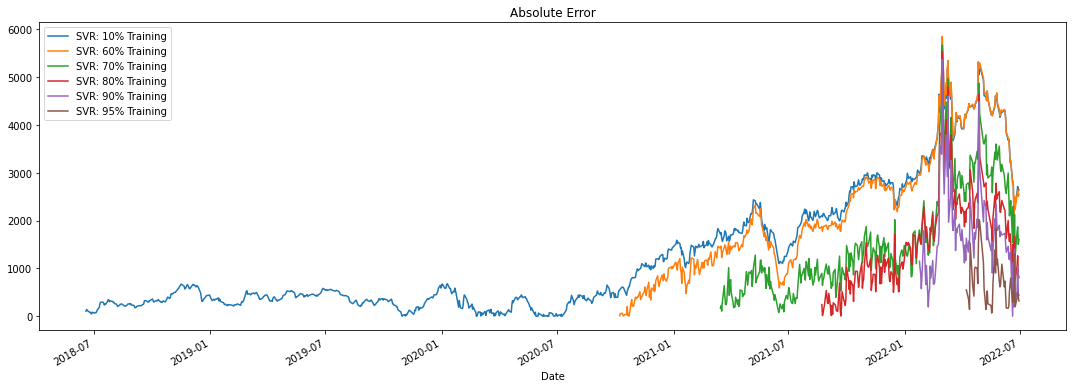

In [ ]:
plt.rcParams["figure.figsize"] = [15, 5.50]
plt.rcParams["figure.autolayout"] = True
fig = diff_df.plot(kind='line', title='Absolute Error')
plt.show()

In [ ]:
col='Prediction'
full_df = pd.DataFrame({'Actual Close': df19['Actual Close'],
                        f'{col} 1:9': df19[f'{col}19'], 
                        f'{col} 6:4': df64[f'{col}64'],
                        f'{col} 7:3': df73[f'{col}73'],
                        f'{col} 8:2': df82[f'{col}82'],
                        f'{col} 9:1': df91[f'{col}91'],
                        f'{col} 9:5': df95[f'{col}95']})
full_df.fillna('-')

,Actual Close,Prediction 1:9,Prediction 6:4,Prediction 7:3,Prediction 8:2,Prediction 9:1,Prediction 9:5
Date,,,,,,,
2018-06-19,2264.0,2368.921389,-,-,-,-,-
2018-06-20,2261.0,2403.595543,-,-,-,-,-
2018-06-21,2254.0,2383.545268,-,-,-,-,-
2018-06-22,2283.0,2394.650338,-,-,-,-,-
2018-06-25,2295.0,2379.434902,-,-,-,-,-
...,...,...,...,...,...,...,...
2022-06-24,4798.0,2448.749754,2566.953304,3546.612129,4052.96176,4457.777582,4597.657563
2022-06-27,5049.0,2448.749754,2519.427124,3285.6868,4004.714905,4533.315965,4664.304378
2022-06-28,5159.0,2448.749754,2521.699987,3290.257533,3894.070075,4111.233052,4670.733871


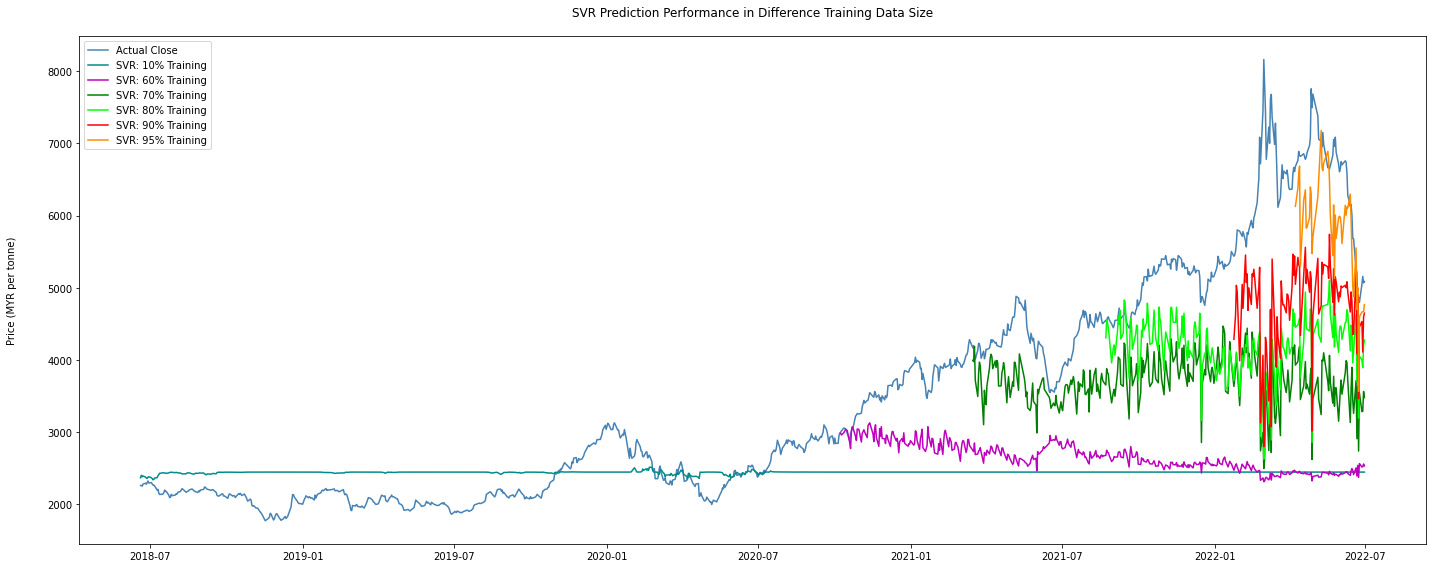

In [ ]:
# visualize the actual and predicted close price
plt.figure(figsize=(20, 8))
plt.plot(full_df['Actual Close'],label='Actual Close',color='steelblue')
plt.plot(full_df['Prediction19'], label='SVR: 10% Training',color='darkcyan')
# plt.plot(full_df['Prediction55'], label='SVR: 50% Training',color='maroon')
plt.plot(full_df['Prediction64'], label='SVR: 60% Training',color='m')
plt.plot(full_df['Prediction73'], label='SVR: 70% Training',color='g')
plt.plot(full_df['Prediction82'], label='SVR: 80% Training',color='lime')
plt.plot(full_df['Prediction91'], label='SVR: 90% Training',color='r')
plt.plot(full_df['Prediction95'], label='SVR: 95% Training',color='darkorange')
plt.title('SVR Prediction Performance in Difference Training Data Size', pad = 20)
plt.ylabel('Price (MYR per tonne)', rotation = 90, labelpad = 30)
plt.legend(loc=0)
plt.show()